In [442]:
import os
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import PathLineSentences, LineSentence, Word2Vec
from pathlib import Path
import networkx as nx
from sklearn import model_selection, linear_model, preprocessing, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
%matplotlib inline


**Load random walks from output files**

The word2vec model requires sentences of strings, so we convert node number to a string.

In [390]:
rw_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/karate-nw/ar")
methods = ["m1", "m2", "m3", "m4"]
# methods = ["m1", "m2", "m3"]
nmethods = len(methods)
vertices = []
for i in range(34):
    vertices.append("v"+str(i+1))
# v = vertices[0]
# v="v30"

num_runs = 5

In [445]:
# G = nx.karate_club_graph()

# G = nx.read_edgelist("/Users/Ganymedian/Desktop/Projects/stellar-random-walk-research/randomwalk/src/test/resources/karate.txt", nodetype=int)
G = nx.read_edgelist("/Users/Ganymedian/Desktop/dynamic-rw/facebook_combined.txt", nodetype=int)
n_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G,nodelist=sorted(G.nodes())).toarray()
d_w = A.sum(axis=1)
M_theory = A.T / d_w
# print(M_theory)
# print(M_theory.T)

1045


In [309]:
def read_walks(v):
    random_walks_int = []

    for m in methods:
        fname = m
        if m != "m1":
            fname = fname+"-"+v
#         print(fname)
        rws = np.concatenate([
            np.loadtxt(f.open(), delimiter='\t', dtype=int)
            for f in rw_location.glob(fname+"-*/part-00000")
            if f.stat().st_size > 0
        ])
#         print(rws.shape)
        random_walks_int.append(rws)
    return random_walks_int
    #     random_walks_str = [list(map(str, v)) for v in random_walks_int]

In [310]:
def extract_runs(random_walks_int):
    all_runs = []
#     print(num_runs)
    for i in range(nmethods):
        ars = np.vsplit(random_walks_int[i], 5)
        print(ars[0].shape)
        all_runs.append(ars)
    return all_runs


Calculate empirical transition probabilities

In [311]:
all_runs = extract_runs(read_walks(v))

(3400, 21)
(3400, 21)
(3400, 21)
(3400, 21)


m1
(17000, 21)
m2-v30
(17000, 21)
m3-v30
(17000, 21)
m4-v30
(17000, 21)
5
(3400, 21)
(3400, 21)
(3400, 21)
(3400, 21)
[0.00201331 0.00137444 0.00106668 0.00093238]
[0.0020973  0.00135032 0.00109253 0.0009408 ]
[0.00208638 0.00132392 0.001053   0.00086474]
[0.00238604 0.00171747 0.0014632  0.00131115]


<function matplotlib.pyplot.show>

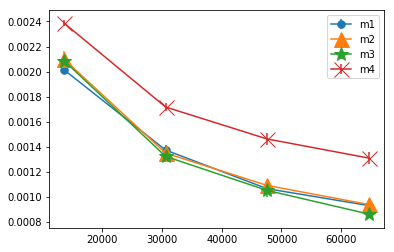

In [276]:
wLength = 6
bucket = 5
formats=['.-', '^-', '*-','x-']
for mm in range(nmethods):
    all_errors = []
    for rr in range(num_runs):
        errors = []
        x_axis = []
        for ii in range(wLength//bucket):
            walk_length = 5*(ii + 1)

            M_empirical = np.zeros((n_nodes, n_nodes))
            for walk in all_runs[mm][rr]:
                for kk in range(walk_length - 1):
                    M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1

            n_samples = M_empirical.sum()
            M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

            errors.append(np.abs(M_theory - M_empirical).mean())
            x_axis.append(n_samples)
        all_errors.append(errors)
    n = len(all_errors)
    means = np.mean(all_errors,axis=0)
#     print(means)
    stdv = np.std(all_errors, axis=0)
    stderr = stdv/np.sqrt(n)
    plt.errorbar(x_axis, means, yerr=stderr, fmt=formats[mm], label=methods[mm], ms=15)
    plt.legend()
plt.show
# plt.plot(x_axis, all_errors, '.-')

Plot for adding different vertices

In [369]:
def read_walks(m, v):
    fname = m
    if m != "m1":
        fname = fname+"-"+v
#     print(fname)
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in rw_location.glob(fname+"-*/part-00000")
        if f.stat().st_size > 0
    ])
#     print(rws.shape)
    ars = np.vsplit(rws, 5)
#     print(ars[0].shape)
    return ars
    #     random_walks_str = [list(map(str, v)) for v in random_walks_int]

reading vertex v1
reading vertex v1
reading vertex v2
reading vertex v3
reading vertex v4
reading vertex v5
reading vertex v6
reading vertex v7
reading vertex v8
reading vertex v9
reading vertex v10
reading vertex v11
reading vertex v12
reading vertex v13
reading vertex v14
reading vertex v15
reading vertex v16
reading vertex v17
reading vertex v18
reading vertex v19
reading vertex v20
reading vertex v21
reading vertex v22
reading vertex v23
reading vertex v24
reading vertex v25
reading vertex v26
reading vertex v27
reading vertex v28
reading vertex v29
reading vertex v30
reading vertex v31
reading vertex v32
reading vertex v33
reading vertex v34
reading vertex v1
reading vertex v2
reading vertex v3
reading vertex v4
reading vertex v5
reading vertex v6
reading vertex v7
reading vertex v8
reading vertex v9
reading vertex v10
reading vertex v11
reading vertex v12
reading vertex v13
reading vertex v14
reading vertex v15
reading vertex v16
reading vertex v17
reading vertex v18
reading vert

<function matplotlib.pyplot.show>

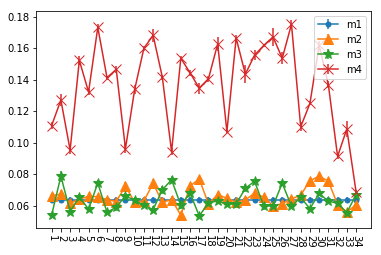

In [372]:
wLength = 6
formats=['.-', '^-', '*-','x-']
walk_length = wLength
x_axis = []
for vv in range(34):
    x_axis.append(vv+1)
for mm in range(nmethods):
    all_errors = []
    for vv in range(34):
        v = "v"+str(vv+1)
        print("reading vertex " + v)
        runs = read_walks(methods[mm], v)
        errors = []
        for rr in range(num_runs):
            M_empirical = np.zeros((n_nodes, n_nodes))
            for walk in runs[rr]:
                for kk in range(walk_length - 1):
                    M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1

            n_samples = M_empirical.sum()
            M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

            errors.append(np.abs(M_theory - M_empirical).max())
        if (methods[mm] == "m1"):
            for vv in range(34):
                all_errors.append(errors)
            break;
        all_errors.append(errors)
    n = len(all_errors)
#     print(n)
    means = np.mean(all_errors,axis=1)
#     print(means)
    stdv = np.std(all_errors, axis=1)
    stderr = stdv/np.sqrt(n)
    plt.errorbar(x_axis, means, yerr=stderr, fmt=formats[mm], label=methods[mm], ms=10)
    plt.xticks(x_axis, rotation=-90)
    plt.legend()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
plt.show
# plt.plot(x_axis, all_errors, '.-')

Increasing walk length

In [446]:
def read_walks(m, v, wl,nw):
    fname = m + "-wl" + str(wl) + "-nw" + str(nw)
    if m != "m1":
        fname = fname+"-"+v
    print(fname)
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in rw_location.glob(fname+"-*/part-00000")
        if f.stat().st_size > 0
    ])
#     print(rws.shape)
    ars = np.vsplit(rws, num_runs)
#     print(ars[0].shape)
    return ars
    #     random_walks_str = [list(map(str, v)) for v in random_walks_int]

reading walk length 100
m1-wl100-nw50
reading walk length 100
m2-wl100-nw50-v0
reading walk length 100
m3-wl100-nw50-v0
reading walk length 100
m4-wl100-nw50-v0


<function matplotlib.pyplot.show>

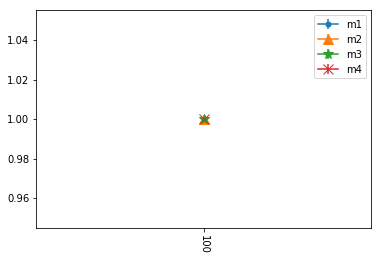

In [449]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
num_runs = 1
rw_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/fb/ar")
methods = ["m1", "m2", "m3", "m4"]
# methods = ["m1", "m2", "m3"]
nmethods = len(methods)
num_walk = 50
# walk_lengths = [3,5,10,20]
walk_lengths = [100]
formats=['.-', '^-', '*-','x-']

x_axis = walk_lengths
v = "v0"
for mm in range(nmethods):
    all_errors = []
    for ww in walk_lengths:
        print("reading walk length " + str(ww))
        runs = read_walks(methods[mm], v, ww, nw)
        errors = []
        for rr in range(num_runs):
            M_empirical = np.zeros((n_nodes, n_nodes))
            for walk in runs[rr]:
                for kk in range(ww - 1):
                    M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1

            n_samples = M_empirical.sum()
            M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

            errors.append(np.abs(M_theory - M_empirical).max())

        all_errors.append(errors)
    n = len(all_errors)
#     print(n)
    means = np.mean(all_errors,axis=1)
#     print(means)
    stdv = np.std(all_errors, axis=1)
    stderr = stdv/np.sqrt(n)
    plt.errorbar(x_axis, means, yerr=stderr, fmt=formats[mm], label=methods[mm], ms=10)
    plt.xticks(x_axis, rotation=-90)
    plt.legend()

plt.show
# plt.plot(x_axis, all_errors, '.-')

Increasing number of walks

reading number of walks 3
m1-wl20-nw3
reading number of walks 5
m1-wl20-nw5
reading number of walks 10
m1-wl20-nw10
reading number of walks 20
m1-wl20-nw20
reading number of walks 50
m1-wl20-nw50
reading number of walks 3
m2-wl20-nw3-v1
reading number of walks 5
m2-wl20-nw5-v1
reading number of walks 10
m2-wl20-nw10-v1
reading number of walks 20
m2-wl20-nw20-v1
reading number of walks 50
m2-wl20-nw50-v1
reading number of walks 3
m3-wl20-nw3-v1
reading number of walks 5
m3-wl20-nw5-v1
reading number of walks 10
m3-wl20-nw10-v1
reading number of walks 20
m3-wl20-nw20-v1
reading number of walks 50
m3-wl20-nw50-v1
reading number of walks 3
m4-wl20-nw3-v1
reading number of walks 5
m4-wl20-nw5-v1
reading number of walks 10
m4-wl20-nw10-v1
reading number of walks 20
m4-wl20-nw20-v1
reading number of walks 50
m4-wl20-nw50-v1


<function matplotlib.pyplot.show>

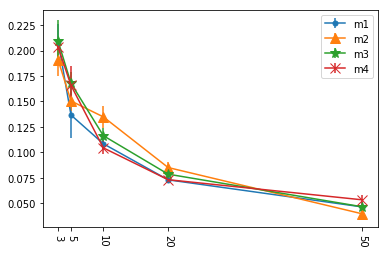

In [401]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

wl = 20
num_walks = [3,5,10,20,50]
formats=['.-', '^-', '*-','x-']

x_axis = num_walks
v = "v1"
for mm in range(nmethods):
    all_errors = []
    for nw in num_walks:
        print("reading number of walks " + str(nw))
        runs = read_walks(methods[mm], v, wl, nw)
        errors = []
        for rr in range(num_runs):
            M_empirical = np.zeros((n_nodes, n_nodes))
            for walk in runs[rr]:
                for kk in range(wl - 1):
                    M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1

            n_samples = M_empirical.sum()
            M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

            errors.append(np.abs(M_theory - M_empirical).max())

        all_errors.append(errors)
    n = len(all_errors)
#     print(n)
    means = np.mean(all_errors,axis=1)
#     print(means)
    stdv = np.std(all_errors, axis=1)
    stderr = stdv/np.sqrt(n)
    plt.errorbar(x_axis, means, yerr=stderr, fmt=formats[mm], label=methods[mm], ms=10)
    plt.xticks(x_axis, rotation=-90)
    plt.legend()

plt.show
# plt.plot(x_axis, all_errors, '.-')

Degrees

<function matplotlib.pyplot.show>

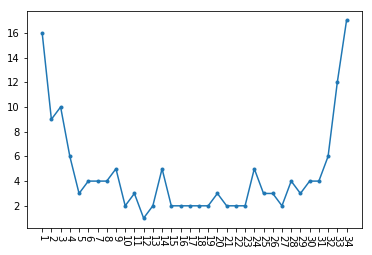

In [361]:
x = sorted(G.nodes())
d = d_w
plt.plot(x, d, '.-',label='degree')
plt.xticks(x_axis, rotation=-90)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
plt.show

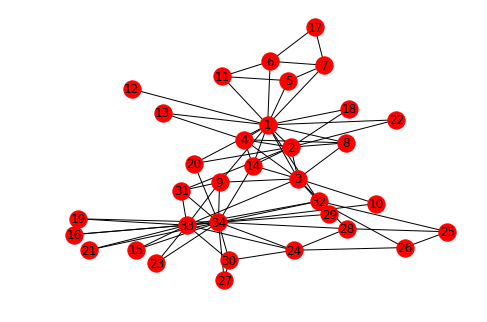

In [362]:
nx.draw(G, with_labels = True)

Plotting number of computation steps

In [436]:
def read_steps(m, wl):
    fname = m + "-steps-to-compute" + "-wl" + str(wl) + ".txt"
#     fname = m + "-walkers-to-compute" + "-wl" + str(wl) + ".txt"
    print(fname)
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in rw_location.glob(fname)
        if f.stat().st_size > 0
    ])
#     print(rws.shape)
#     ars = np.vsplit(rws, 5)
#     print(ars[0].shape)
    return rws
    #     random_walks_str = [list(map(str, v)) for v in random_walks_int]

reading walk length 3
m1-steps-to-compute-wl3.txt
reading walk length 5
m1-steps-to-compute-wl5.txt
reading walk length 10
m1-steps-to-compute-wl10.txt
reading walk length 20
m1-steps-to-compute-wl20.txt
reading walk length 3
m2-steps-to-compute-wl3.txt
reading walk length 5
m2-steps-to-compute-wl5.txt
reading walk length 10
m2-steps-to-compute-wl10.txt
reading walk length 20
m2-steps-to-compute-wl20.txt
reading walk length 3
m3-steps-to-compute-wl3.txt
reading walk length 5
m3-steps-to-compute-wl5.txt
reading walk length 10
m3-steps-to-compute-wl10.txt
reading walk length 20
m3-steps-to-compute-wl20.txt
reading walk length 3
m4-steps-to-compute-wl3.txt
reading walk length 5
m4-steps-to-compute-wl5.txt
reading walk length 10
m4-steps-to-compute-wl10.txt
reading walk length 20
m4-steps-to-compute-wl20.txt


<function matplotlib.pyplot.show>

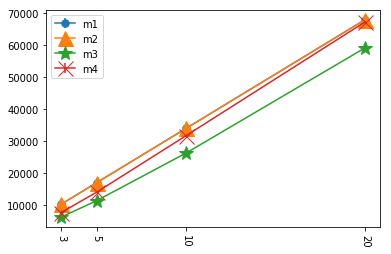

In [441]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

methods = ["m1", "m2", "m3", "m4"]
rw_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/karate-wl/")
walk_lengths = [3,5,10,20]
formats=['.-', '^-', '*-','x-']

x_axis = walk_lengths
for mm in range(len(methods)):
    means = []
    errors = []
    for ww in walk_lengths:
        print("reading walk length " + str(ww))
        runs = read_steps(methods[mm], ww)[1:]

        n = len(runs)
#         print(n)
        mean = np.mean(runs,axis=0)[0]
        stdv = np.std(runs, axis=0)[0]
        stderr = stdv/np.sqrt(n)
        means.append(mean)
        errors.append(stderr)
    plt.errorbar(x_axis, means, yerr=errors, fmt=formats[mm], label=methods[mm], ms=15)
    plt.xticks(x_axis, rotation=-90)
    plt.legend()

plt.show
# plt.plot(x_axis, all_errors, '.-')

In [405]:
errors_nw = []
x_axis_nw = []
walk_length = random_walks_int.shape[1]
for ii in range(20):
    #walk_length = 5*(ii + 1)
    #walk_lengths.append(walk_length)
    
    num_walks = 5*(ii + 1)

    reduced_walks = []
    for kk in range(1, n_nodes+1):
        reduced_walks.append(
            random_walks_int[random_walks_int[:, 0] == kk][:num_walks]
        )
    reduced_walks = np.concatenate(reduced_walks)
    
    M_empirical = np.zeros((n_nodes, n_nodes))
    for walk in reduced_walks:
        for kk in range(walk_length - 1):
            M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1
    n_samples = M_empirical.sum()
    M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

    errors_nw.append(np.abs(M_theory - M_empirical).max())
    x_axis_nw.append(n_samples)

plt.plot(x_axis_nw, errors_nw, '.-')
plt.plot(x_axis, errors, '--')

AttributeError: 'list' object has no attribute 'shape'

0.9395079594790159
0.028741502372561713
3.3536124073059748


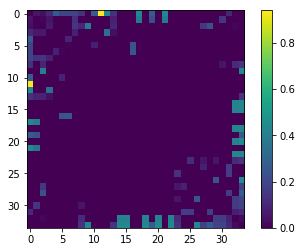

In [117]:
plt.imshow(np.abs(M_theory - M_empirical))
plt.colorbar()
error = np.abs(M_theory - M_empirical).max()
print(error)
error = np.abs(M_theory - M_empirical).mean()
print(error)
error = np.linalg.norm(M_theory - M_empirical)
print(error)

In [ ]:
import sys
sys.path.append("/Users/doc019/Code/stellar-evaluation-plugins")
from utils.epgm import EPGM

Theoretical transition probabilities

In [ ]:
error = np.abs(M_theory - M_empirical).max()
#error = np.linalg.norm(M_theory - M_empirical)
error

Train word2vec embeddings using gensim

In [550]:
def read_paths(fname):
#     fname = m + "-steps-to-compute" + "-wl" + str(wl) + ".txt"
# #     fname = m + "-walkers-to-compute" + "-wl" + str(wl) + ".txt"
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in rw_location.glob(fname+"/part-00000")
        if f.stat().st_size > 0
    ])
    rw_str = [list(map(str, v)) for v in rws]

    return rw_str     

In [627]:
rw_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/karate-wl/ar")
fname = "m4-wl5-v1-0"
random_walks_str = read_paths(fname)


In [628]:
dim = 20
model = Word2Vec(random_walks_str, sg=1, size=dim, window=5, sample=0, min_count=0, 
                 workers=4, seed=1321, iter=10, compute_loss=True)

In [629]:
model.get_latest_training_loss()

793446.1875

Save embeddings

In [630]:
dir = "/Users/Ganymedian/Desktop/dynamic-rw/karate-wl/"
model.wv.save_word2vec_format(dir+"/embeddings.txt")

Extract embeddings as matrix of size `n_nodes` × `d`

In [631]:
def read_labels(fname):
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in l_location.glob(fname)
        if f.stat().st_size > 0
    ])

    return rws  

In [632]:
# Labels must be sorted based on the node IDs
l_location = Path("/Users/Ganymedian/Desktop/dynamic-rw")
fname = "karate-labels.txt"
v_labels = read_labels(fname)
nodes = v_labels[:,0]
node_labels = v_labels[:,1]
print(nodes)
print(node_labels)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2]


In [633]:
V_w2v = np.ndarray(shape=(len(nodes),dim), dtype=float)
for v in nodes:
    V_w2v[v-1] = model.wv[str(v)]
n_nodes, d_emb = V_w2v.shape
# print(V_w2v)
print(n_nodes)
print(d_emb)

34
20


In [634]:
# V_w2v = model.wv.syn0
# n_nodes, d_emb = V_w2v.shape
# # print(V_w2v)


Node labels:

In [635]:
# node_labels = np.zeros(n_nodes)
# node_labels[:10] = 1

Read node labels

**Classification using single train/test split**

In [636]:
# Split using sklearn ShuffleSplit
ss = model_selection.ShuffleSplit(n_splits=1,
                                  train_size=0.5,
                                  test_size=0.5)
train_index, test_index = next(ss.split(V_w2v))

In [637]:
train_data = V_w2v[train_index]
test_data = V_w2v[test_index]
train_labels = node_labels[train_index]
test_labels  = node_labels[test_index]
print(train_labels)
print(test_labels)

[1 1 2 2 1 1 1 1 1 2 2 1 1 1 1 2 2]
[1 2 2 2 1 1 2 1 1 2 1 2 2 2 2 2 2]


In [638]:
# Classifier choice
#classifier = linear_model.LogisticRegression(C=10)
classifier = svm.SVC(C=1)

clf = make_pipeline(preprocessing.StandardScaler(), classifier)
clf.fit(train_data, train_labels)

train_pred = clf.predict(train_data)
test_pred = clf.predict(test_data)
print(train_pred)
print(test_pred)

print("Train acc:", clf.score(train_data, train_labels))
print("Test acc:", clf.score(test_data, test_labels))
print("Train f1:", f1_score(train_labels, train_pred, average='micro'))
print("Test f1:", f1_score(test_labels, test_pred, average='micro'))

[1 1 2 2 1 1 1 1 1 2 2 1 1 1 1 2 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1]
Train acc: 1.0
Test acc: 0.4117647058823529
Train f1: 1.0
Test f1: 0.4117647058823529


**K-fold cross validation**

In [639]:
kf = model_selection.KFold(n_splits=4, shuffle=True)

acc_test_scores = []
f1_test_scores = []
for train_index, test_index in kf.split(V_w2v):
    train_data = V_w2v[train_index]
    test_data = V_w2v[test_index]
    train_labels = node_labels[train_index]
    test_labels  = node_labels[test_index]
    
    # Classifier choice
    #classifier = linear_model.LogisticRegression(C=10)
    classifier = svm.SVC(C=1)

    clf = make_pipeline(preprocessing.StandardScaler(), classifier)
    clf.fit(train_data, train_labels)

    train_pred = clf.predict(train_data)
    test_pred = clf.predict(test_data)

    acc_train = clf.score(train_data, train_labels)
    acc_test = clf.score(test_data, test_labels)
    f1_train = f1_score(train_labels, train_pred, average='micro')
    f1_test = f1_score(test_labels, test_pred, average='micro')
    
    acc_test_scores.append(acc_test)
    f1_test_scores.append(f1_test)
    
    print("Train acc={:4f},  Test acc={:4f},  Train f1={:4f},  Test f1={:4f}".format(
        acc_train, acc_test, f1_train, f1_test
    ))
    
print("Average scores:")
print("Avg test acc={:4f} [±{:2f}],  Avg test f1={:4f} [±{:2f}]".format(
    np.mean(acc_test_scores), np.std(acc_test_scores), 
    np.mean(f1_test_scores), np.std(f1_test_scores)
))

Train acc=1.000000,  Test acc=1.000000,  Train f1=1.000000,  Test f1=1.000000
Train acc=1.000000,  Test acc=0.888889,  Train f1=1.000000,  Test f1=0.888889
Train acc=1.000000,  Test acc=1.000000,  Train f1=1.000000,  Test f1=1.000000
Train acc=1.000000,  Test acc=0.875000,  Train f1=1.000000,  Test f1=0.875000
Average scores:
Avg test acc=0.940972 [±0.059232],  Avg test f1=0.940972 [±0.059232]
